# importing libraries

In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
#models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
#metrics
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix, classification_report

# Reading Data

In [2]:
rs = 0
df = pd.read_csv(f'MCSDatasetNEXTCONLab.csv')
df['Ligitimacy'] = df['Ligitimacy'].replace(0,-1)
trDf = df[:10139][:]
teDf = df[10139:][:]
trDf = trDf.apply(lambda x: (x-45)*10000 if x.name == 'Latitude' else x)
trDf = trDf.apply(lambda x: (x+75)*10000 if x.name == 'Longitude' else x)
teDf = teDf.apply(lambda x: (x-45)*10000 if x.name == 'Latitude' else x)
teDf = teDf.apply(lambda x: (x+75)*10000 if x.name == 'Longitude' else x)
trY = trDf['Ligitimacy'].values
teY = teDf['Ligitimacy'].values
trX = trDf.drop(columns=['ID', 'Day', 'Ligitimacy']).values
teX = teDf.drop(columns=['ID', 'Day', 'Ligitimacy']).values

In [3]:
trDf

,ID,Latitude,Longitude,Day,Hour,Minute,Duration,RemainingTime,Resources,Coverage,OnPeakHours,GridNumber,Ligitimacy
0,1,4421.4189,-3033.6925,1,4,13,40,40,9,91,0,131380,1
1,1,4421.5414,-3043.6606,1,4,23,40,30,9,91,0,131380,1
2,1,4421.0414,-3039.6326,1,4,33,40,20,9,91,0,121996,1
3,1,4418.6802,-3035.7741,1,4,43,40,10,9,91,0,121996,1
4,2,4477.2690,-1477.2228,2,15,49,30,30,5,47,0,140784,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10134,2820,5398.0715,-1363.8483,3,4,50,40,20,1,87,0,290929,1
10135,2820,5404.4717,-1361.2367,3,5,0,40,10,1,87,0,300313,1
10136,2821,5435.2708,-2177.0007,2,19,44,40,40,5,35,0,300303,1
10137,2821,5435.5436,-2178.3546,2,19,54,40,30,5,35,0,300303,1


In [4]:
# converting to data frame
xtrain = pd.DataFrame(trX,columns = ["Latitude", "Longitude", "Hour", "Minute", "Duration", "RemainingTime", "Resources", "Coverage", "OnPeakHours", "GridNumber"]) 
xtest = pd.DataFrame(teX,columns = ["Latitude", "Longitude", "Hour", "Minute", "Duration", "RemainingTime", "Resources", "Coverage", "OnPeakHours", "GridNumber"])
ytrain =pd.DataFrame(trY,columns = ["Ligitimacy"])
ytest =pd.DataFrame(teY,columns = ["Ligitimacy"])

In [5]:
xtrain

,Latitude,Longitude,Hour,Minute,Duration,RemainingTime,Resources,Coverage,OnPeakHours,GridNumber
0,4421.4189,-3033.6925,4.0,13.0,40.0,40.0,9.0,91.0,0.0,131380.0
1,4421.5414,-3043.6606,4.0,23.0,40.0,30.0,9.0,91.0,0.0,131380.0
2,4421.0414,-3039.6326,4.0,33.0,40.0,20.0,9.0,91.0,0.0,121996.0
3,4418.6802,-3035.7741,4.0,43.0,40.0,10.0,9.0,91.0,0.0,121996.0
4,4477.2690,-1477.2228,15.0,49.0,30.0,30.0,5.0,47.0,0.0,140784.0
...,...,...,...,...,...,...,...,...,...,...
10134,5398.0715,-1363.8483,4.0,50.0,40.0,20.0,1.0,87.0,0.0,290929.0
10135,5404.4717,-1361.2367,5.0,0.0,40.0,10.0,1.0,87.0,0.0,300313.0
10136,5435.2708,-2177.0007,19.0,44.0,40.0,40.0,5.0,35.0,0.0,300303.0
10137,5435.5436,-2178.3546,19.0,54.0,40.0,30.0,5.0,35.0,0.0,300303.0


### check for null values

In [6]:
print(xtrain.isnull().values.any())
print(xtest.isnull().values.any())
print(ytrain.isnull().values.any())
print(ytest.isnull().values.any())

False
False
False
False


### data correlations

<AxesSubplot:>

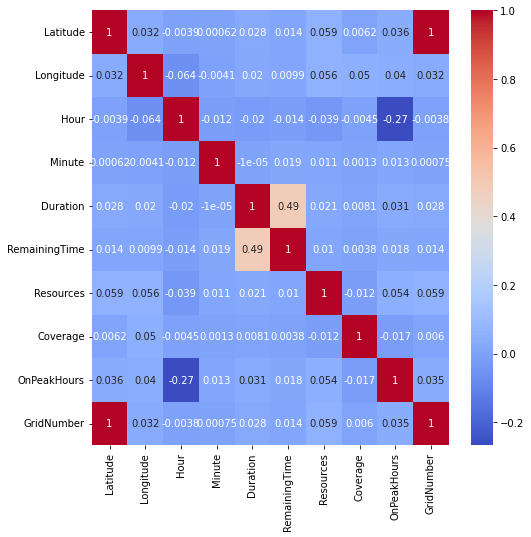

In [7]:
# Plot the coorelation between features
plt.figure(figsize=(8,8))
sns.heatmap(xtrain.corr(), annot = True, cmap = 'coolwarm')

## comment
There are a positive correlation between both GriNumber and Latitude

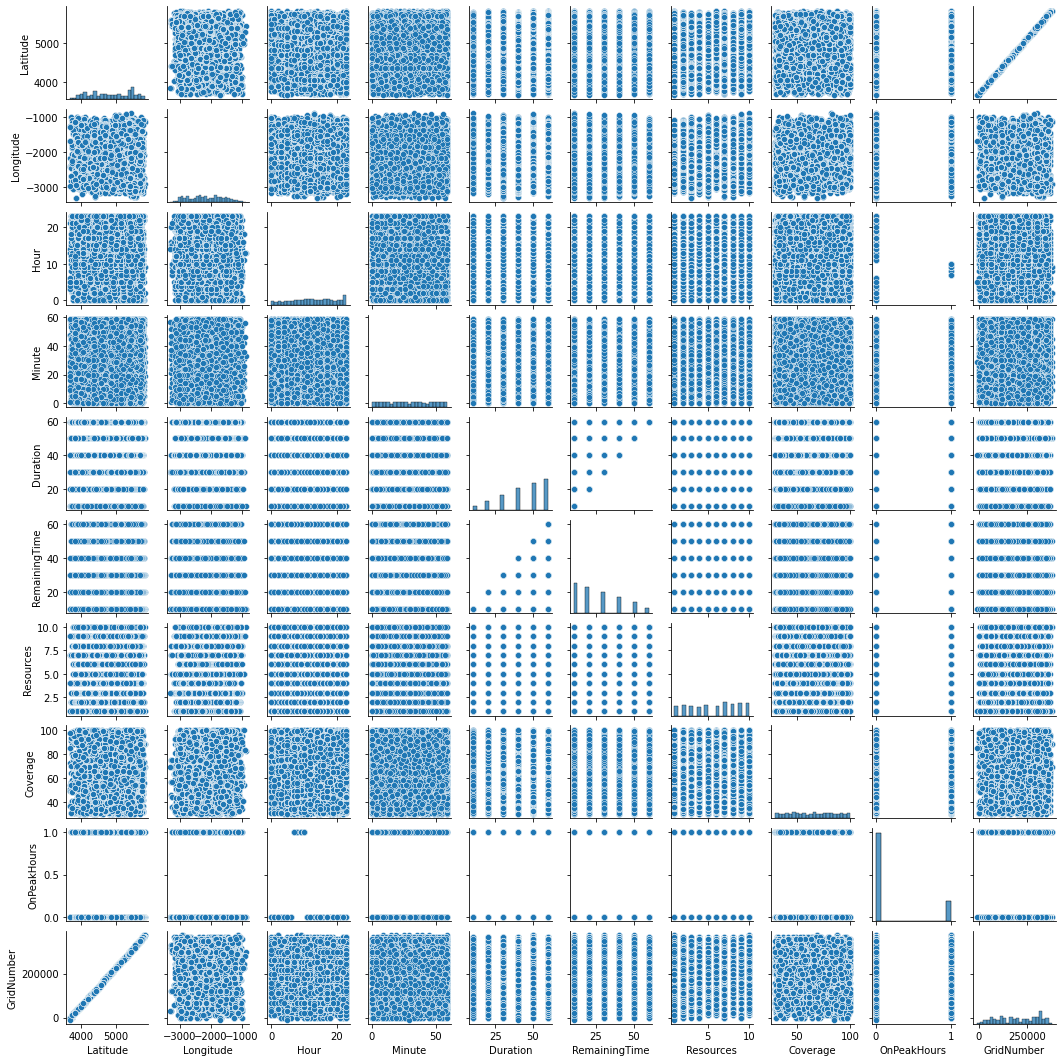

In [8]:
sns.pairplot(xtrain, height = 1.5)

# Functions

In [9]:
def model_Boosting(nEst, lr, x_train, y_train, x_test, y_test):
    classifier = AdaBoostClassifier(n_estimators = nEst, learning_rate = lr, random_state=0)
    classifier.fit(x_train, y_train)
    ypred = classifier.predict(x_test)
    accuracy = accuracy_score(y_test, ypred)
    print(accuracy)
    plot_confusion_matrix(classifier, x_test, y_test)

    return classifier, ypred, accuracy

In [10]:
def model_knn(x_train, y_train, x_test, y_test):
    classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2) #choosing Euclidean distance metric
    classifier.fit(x_train, y_train)
    ypred = classifier.predict(x_test)
    accuracy = accuracy_score(y_test, ypred)
    print(accuracy)
    plot_confusion_matrix(classifier, x_test, y_test)
    
    return classifier, ypred, accuracy

In [11]:
def model_decisiontree(x_train, y_train, x_test, y_test):
    classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    classifier.fit(x_train, y_train)
    ypred = classifier.predict(x_test)
    accuracy = accuracy_score(y_test, ypred)
    print(accuracy)
    plot_confusion_matrix(classifier, x_test, y_test)
    
    return classifier, ypred, accuracy

In [12]:
# def model_svm(x_train, y_train, x_test, y_test):
#     classifier = SVC(kernel = 'sigmoid', random_state = 0)
#     classifier.fit(x_train, y_train)
#     ypred = classifier.predict(x_test)
#     accuracy = accuracy_score(y_test, ypred)
#     print(accuracy)
#     plot_confusion_matrix(classifier, x_test, y_test)
    
#     return classifier, ypred, accuracy

In [13]:
# def model_logisticregression(x_train, y_train, x_test, y_test):
#     classifier = LogisticRegression(random_state = 0)
#     classifier.fit(x_train, y_train)
#     ypred = classifier.predict(x_test)
#     accuracy = accuracy_score(y_test, ypred)
#     print(accuracy)
#     plot_confusion_matrix(classifier, x_test, y_test)
    
#     return classifier, ypred, accuracy

# Implementation

## Baseline estimators

1) I tried to fit the models directly to the data, then dropped one of the correlated columns.
by comparing the accuracies, I found that I should not drop the feature, as the accuracy of the models fall down

2) Choose the three models that give the best accuracies and use them as baseline estimaotrs
("AdaBoost", "K-NN", "Decision-Tree")

C:\Users\hadyo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.9650172612197928


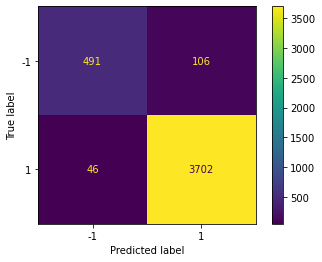

In [14]:
ada_model, ada_pred, ada_accuracy= model_Boosting(100, 1, xtrain, ytrain, xtest, ytest)

C:\Users\hadyo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.980897583429229


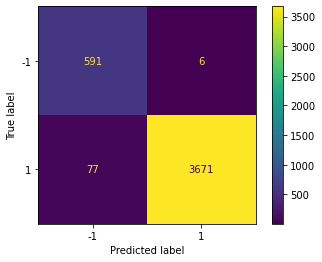

In [15]:
knn_model, knn_pred, knn_accuracy= model_knn(xtrain, ytrain, xtest, ytest)

0.9535097813578827


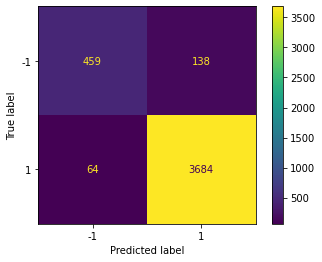

In [16]:
dt_model, dt_pred, dt_accuracy = model_decisiontree(xtrain, ytrain, xtest, ytest)

In [17]:
# lr_model, lr_pred, lr_accuracy = model_logisticregression(xtrain, ytrain, xtest, ytest)

In [18]:
# svm_model, svm_pred, svm_accuracy = model_svm(xtrain, ytrain, xtest, ytest)

In [19]:
# # try to drop one of the correlated columns
# new_train_x = xtrain.drop(labels = 'GridNumber', axis = 1)
# new_test_x = xtest.drop(labels = 'GridNumber', axis = 1)

In [20]:
# ada_model_new, ada_pred_new, ada_accuracy_new = model_Boosting(100, 1, new_train_x, ytrain, new_test_x, ytest)

In [21]:
# knn_model, knn_pred, knn_accuracy= model_knn(new_train_x, ytrain, new_test_x, ytest)

In [22]:
# dt_model, dt_pred, dt_accuracy = model_decisiontree(new_train_x, ytrain, new_test_x, ytest)

In [ ]:
# plot barchart
